In [1]:
from pathlib import Path
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import torch
from torch import nn
from torchvision.models import resnet50, resnet101
from torch.autograd import Variable
import torchvision
from torch.utils.data import Dataset
import time

In [2]:
import os
import multiprocessing
import numpy as np
from tqdm import tqdm
from functools import partial
import cv2
import numba as nb

@nb.jit(nopython=True)
def estimate_light_distribution(width, height, erosion, cei, int_img):
    """Parameters:
        width: Width of the image.
        height: Height of the image.
        erosion: Eroded image.
        cei: Contrast enhanced image.
        int_img: Integrated image.
        
        -- This function estimates the light 
        distribution in the image using a specific algorithm."""

    for y in range(width):
        for x in range(height):
            if erosion[x][y] == 0:
                i = x

                while i < erosion.shape[0] and erosion[i][y] == 0:
                    i += 1

                end = i - 1
                n = end - x + 1

                if n <= 30:
                    h, e = [], []

                    for k in range(5):
                        if x - k >= 0:
                            h.append(cei[x - k][y])

                        if end + k < cei.shape[0]:
                            e.append(cei[end + k][y])

                    mpv_h, mpv_e = max(h), max(e)

                    for m in range(n):
                        int_img[x + m][y] = mpv_h + (m + 1) * ((mpv_e - mpv_h) / n)

                x = end
                break


def illumination_compensation(img, only_cei=False):
    """"
    Performs illumination compensation on a text image.

    Args:
        img: Input text image (numpy array).
        only_cei: If True, returns only the Contrast Enhanced Image (CEI), 
        otherwise returns the compensated image.

    Returns:
        Compensated image or CEI (numpy array).

    Overview:
    This function performs illumination compensation for text images by first 
    binarizing the input image and identifying high-intensity regions. 
    It then enhances contrast and extracts edges before estimating light 
    distribution and applying compensation to improve image quality, 
    particularly enhancing text readability.

    """

    _, binary = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)

    if np.sum(binary) > np.sum(img) * 0.8:
        return np.asarray(img, dtype=np.uint8)

    def scale(img):
        s = np.max(img) - np.min(img)
        res = img / s
        res -= np.min(res)
        res *= 255
        return res

    img = img.astype(np.float32)
    height, width = img.shape
    sqrt_hw = np.sqrt(height * width)

    bins = np.arange(0, 300, 10)
    bins[26] = 255
    hp = np.histogram(img, bins)

    for i in range(len(hp[0])):
        if hp[0][i] > sqrt_hw:
            hr = i * 10
            break

    np.seterr(divide='ignore', invalid='ignore')
    cei = (img - (hr + 50 * 0.3)) * 2
    cei[cei > 255] = 255
    cei[cei < 0] = 0

    if only_cei:
        return np.asarray(cei, dtype=np.uint8)

    m1 = np.asarray([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape((3, 3))
    m2 = np.asarray([-2, -1, 0, -1, 0, 1, 0, 1, 2]).reshape((3, 3))
    m3 = np.asarray([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape((3, 3))
    m4 = np.asarray([0, 1, 2, -1, 0, 1, -2, -1, 0]).reshape((3, 3))

    eg1 = np.abs(cv2.filter2D(img, -1, m1))
    eg2 = np.abs(cv2.filter2D(img, -1, m2))
    eg3 = np.abs(cv2.filter2D(img, -1, m3))
    eg4 = np.abs(cv2.filter2D(img, -1, m4))

    eg_avg = scale((eg1 + eg2 + eg3 + eg4) / 4)

    h, w = eg_avg.shape
    eg_bin = np.zeros((h, w))
    eg_bin[eg_avg >= 30] = 255

    h, w = cei.shape
    cei_bin = np.zeros((h, w))
    cei_bin[cei >= 60] = 255

    h, w = eg_bin.shape
    tli = 255 * np.ones((h, w))
    tli[eg_bin == 255] = 0
    tli[cei_bin == 255] = 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(tli, kernel, iterations=1)
    int_img = np.asarray(cei)

    estimate_light_distribution(width, height, erosion, cei, int_img)

    mean_filter = 1 / 121 * np.ones((11, 11), np.uint8)
    ldi = cv2.filter2D(scale(int_img), -1, mean_filter)

    result = np.divide(cei, ldi) * 260
    result[erosion != 0] *= 1.5
    result[result < 0] = 0
    result[result > 255] = 255

    return np.asarray(result, dtype=np.uint8)


def sauvola(img, window, thresh, k):
    """
    Sauvola binarization.
    It calculates local statistics within a defined window, 
    including mean and standard deviation, 
    to determine optimal thresholds for binarization.
    """

    rows, cols = img.shape
    pad = int(np.floor(window[0] / 2))
    sum2, sqsum = cv2.integral2(
        cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT))

    isum = sum2[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sum2[0:rows, 0:cols] - \
        sum2[window[0]:rows + window[0], 0:cols] - \
        sum2[0:rows, window[1]:cols + window[1]]

    isqsum = sqsum[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sqsum[0:rows, 0:cols] - \
        sqsum[window[0]:rows + window[0], 0:cols] - \
        sqsum[0:rows, window[1]:cols + window[1]]

    ksize = window[0] * window[1]
    mean = isum / ksize
    std = (((isqsum / ksize) - (mean**2) / ksize) / ksize) ** 0.5
    threshold = (mean * (1 + k * (std / thresh - 1))) * (mean >= 100)

    return np.asarray(255 * (img >= threshold), 'uint8')

def remove_cursive_style(img):
    """Remove cursive writing style from image with deslanting algorithm
    It first applies binarization techniques such as Otsu's thresholding to obtain a binary image. 
    Then, it iterates through different shear transformations with varying angles to find the optimal deslanting angle, 
    After applying the chosen transformation to the input image and returns the deslanted result. """

    def calc_y_alpha(vec):
        indices = np.where(vec > 0)[0]
        h_alpha = len(indices)

        if h_alpha > 0:
            delta_y_alpha = indices[h_alpha - 1] - indices[0] + 1

            if h_alpha == delta_y_alpha:
                return h_alpha * h_alpha
        return 0

    alpha_vals = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
    rows, cols = img.shape
    results = []

    ret, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = otsu if ret < 127 else sauvola(img, (int(img.shape[0] / 2), int(img.shape[0] / 2)), 127, 1e-2)

    for alpha in alpha_vals:
        shift_x = max(-alpha * rows, 0.)
        size = (cols + int(np.ceil(abs(alpha * rows))), rows)
        transform = np.asarray([[1, alpha, shift_x], [0, 1, 0]], dtype=np.float32)

        shear_img = cv2.warpAffine(binary, transform, size, cv2.INTER_NEAREST)
        sum_alpha = 0
        sum_alpha += np.apply_along_axis(calc_y_alpha, 0, shear_img)
        results.append([np.sum(sum_alpha), size, transform])

    result = sorted(results, key=lambda x: x[0], reverse=True)[0]
    result = cv2.warpAffine(img, result[2], result[1], borderValue=255)
    result = cv2.resize(result, dsize=(cols, rows))

    return np.asarray(result, dtype=np.uint8)

def preprocess(img, input_size):
    """Make the process with the `input_size` to the scale resize"""

    def imread(path):
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

        if len(img.shape) == 3:
            if img.shape[2] == 4:
                trans_mask = img[:, :, 3] == 0
                img[trans_mask] = [255, 255, 255, 255]

            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        return img

    if isinstance(img, str):
        img = imread(img)

    if isinstance(img, tuple):
        image, boundbox = img
        img = imread(image)

        for i in range(len(boundbox)):
            if isinstance(boundbox[i], float):
                total = len(img) if i < 2 else len(img[0])
                boundbox[i] = int(total * boundbox[i])

        img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

    wt, ht, _ = input_size
    h, w = np.asarray(img).shape
    f = max((w / wt), (h / ht))
    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))

    img = illumination_compensation(img)
    img = remove_cursive_style(img)
    img = cv2.resize(img, new_size)

    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    img = cv2.transpose(target)

    return img

def preprocess_images_in_folder(folder_path, input_size):
    """Preprocess images in a folder"""
    image_files = os.listdir(folder_path)
    results = []
    print(f"Processing images in folder: {folder_path}")
    for img_file in tqdm(image_files):
        image_path = os.path.join(folder_path, img_file)
        result = preprocess(image_path, input_size)
        results.append(result)
    return result




In [3]:
import html
import string
import re

def normalization(img):
    """Normalize list of image"""
    
    m, s = cv2.meanStdDev(img)
    img = img - m[0][0]
    img = img / s[0][0] if s[0][0] > 0 else img
    return img


RE_DASH_FILTER = re.compile(r'[\-\˗\֊\‐\‑\‒\–\—\⁻\₋\−\﹣\－]', re.UNICODE)
RE_APOSTROPHE_FILTER = re.compile(r'&#39;|[ʼ՚＇‘’‛❛❜ߴߵ`‵´ˊˋ{}{}{}{}{}{}{}{}{}]'.format(
    chr(768), chr(769), chr(832), chr(833), chr(2387),
    chr(5151), chr(5152), chr(65344), chr(8242)), re.UNICODE)
RE_RESERVED_CHAR_FILTER = re.compile(r'[¶¤«»]', re.UNICODE)
RE_LEFT_PARENTH_FILTER = re.compile(r'[\(\[\{\⁽\₍\❨\❪\﹙\（]', re.UNICODE)
RE_RIGHT_PARENTH_FILTER = re.compile(r'[\)\]\}\⁾\₎\❩\❫\﹚\）]', re.UNICODE)
RE_BASIC_CLEANER = re.compile(r'[^\w\s{}]'.format(re.escape(string.punctuation)), re.UNICODE)

LEFT_PUNCTUATION_FILTER = """!%&),.:;<=>?@\\]^_`|}~"""
RIGHT_PUNCTUATION_FILTER = """"(/<=>@[\\^_`{|~"""
NORMALIZE_WHITESPACE_REGEX = re.compile(r'[^\S\n]+', re.UNICODE)
    
def text_standardize(text):
    """Organize/add spaces around punctuation marks"""

    if text is None:
        return ""

    text = html.unescape(text).replace("\\n", "").replace("\\t", "")

    text = RE_RESERVED_CHAR_FILTER.sub("", text)
    text = RE_DASH_FILTER.sub("-", text)
    text = RE_APOSTROPHE_FILTER.sub("'", text)
    text = RE_LEFT_PARENTH_FILTER.sub("(", text)
    text = RE_RIGHT_PARENTH_FILTER.sub(")", text)
    text = RE_BASIC_CLEANER.sub("", text)

    text = text.lstrip(LEFT_PUNCTUATION_FILTER)
    text = text.rstrip(RIGHT_PUNCTUATION_FILTER)
    text = text.translate(str.maketrans({c: f" {c} " for c in string.punctuation}))
    text = NORMALIZE_WHITESPACE_REGEX.sub(" ", text.strip())

    return text

In [4]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=128):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class OCR(nn.Module):

    def __init__(self, vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers):
        super().__init__()

        # create ResNet-101 backbone
        self.backbone = resnet101()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads with length of vocab
        # DETR used basic 3 layer MLP for output
        self.vocab = nn.Linear(hidden_dim,vocab_len)

        # output positional encodings (object queries)
        self.decoder = nn.Embedding(vocab_len, hidden_dim)
        self.query_pos = PositionalEncoding(hidden_dim, .2)

        # spatial positional encodings, sine positional encoding can be used.
        # Detr baseline uses sine positional encoding.
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.trg_mask = None
  
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask

    def get_feature(self,x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)   
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        return x


    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)


    def forward(self, inputs, trg):
        # propagate inputs through ResNet-101 up to avg-pool layer
        x = self.get_feature(inputs)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        bs,_,H, W = h.shape
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # generating subsequent mask for target
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(trg.shape[1]).to(trg.device)

        # Padding mask
        trg_pad_mask = self.make_len_mask(trg)

        # Getting postional encoding for target
        trg = self.decoder(trg)
        trg = self.query_pos(trg)
        
        output = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), trg.permute(1,0,2), tgt_mask=self.trg_mask, 
                                  tgt_key_padding_mask=trg_pad_mask.permute(1,0))

        return self.vocab(output.transpose(0,1))


def make_model(vocab_len, hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4):
    
    return OCR(vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers)

In [5]:
"""
Uses generator functions to supply train/test with data.
Image renderings and text are created on the fly each time.
"""

class DataGenerator(Dataset):
    """Generator class with data streaming"""

    def __init__(self, source,charset, max_text_length, split, transform):
        self.tokenizer = Tokenizer(charset, max_text_length)
        self.transform = transform
        
        self.split = split
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            self.dataset[self.split] = dict()

            self.dataset[self.split]['dt'] = np.array(f[self.split]['dt'])
            self.dataset[self.split]['gt'] = np.array(f[self.split]['gt'])
          
            randomize = np.arange(len(self.dataset[self.split]['gt']))
            np.random.seed(42)
            np.random.shuffle(randomize)

            self.dataset[self.split]['dt'] = self.dataset[self.split]['dt'][randomize]
            self.dataset[self.split]['gt'] = self.dataset[self.split]['gt'][randomize]

            # decode sentences from byte
            self.dataset[self.split]['gt'] = [x.decode() for x in self.dataset[self.split]['gt']]
            
        self.size = len(self.dataset[self.split]['gt'])


    def __getitem__(self, i):
        img = self.dataset[self.split]['dt'][i]
        
        #making image compatible with resnet
        img = np.repeat(img[..., np.newaxis],3, -1)    
        img = normalization(img)
        
        if self.transform is not None:
            img = self.transform(img)

        y_train = self.tokenizer.encode(self.dataset[self.split]['gt'][i]) 
        
        #padding till max length
        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)

        return img, gt          

    def __len__(self):
      return self.size



class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK,self.SOS,self.EOS = "¶", "¤", "SOS", "EOS"
        self.chars = [self.PAD_TK] + [self.UNK_TK ]+ [self.SOS] + [self.EOS] +list(chars)
        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""

        text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        text = ['SOS'] + list(text) + ['EOS']
        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""
        
        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")



In [6]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx=0, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


In [7]:
import os
import datetime
import string

batch_size = 16
epochs = 200


source = 'bentham'
source_path = '/kaggle/input/bentham-dataset/bentham.hdf5'
output_path = os.path.join("..", "output", source)
target_path = os.path.join(output_path, "checkpoint_weights_iam.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: /kaggle/input/bentham-dataset/bentham.hdf5
output ../output/bentham
target ../output/bentham/checkpoint_weights_iam.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [8]:
import torchvision.transforms as T

device = torch.device("cuda")
transform = T.Compose([
    T.ToTensor()])

In [9]:
tokenizer = Tokenizer(charset_base)


In [10]:
train_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'train',transform), batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'valid',transform), batch_size=batch_size, shuffle=False, num_workers=2)


In [11]:
model = make_model(vocab_len=tokenizer.vocab_size)
_=model.to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
criterion = LabelSmoothing(size=tokenizer.vocab_size, padding_idx=0, smoothing=0.1)
criterion.to(device)
lr = .0001 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=.0004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)


/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [27]:
def train(model, criterion, optimiser, scheduler,dataloader):
 
    model.train()
    total_loss = 0
    for batch, (imgs, labels_y,) in enumerate(dataloader):
          imgs = imgs.to(device)
          labels_y = labels_y.to(device)
    
          optimiser.zero_grad()
          output = model(imgs.float(),labels_y.long()[:,:-1])
 
          norm = (labels_y != 0).sum()
          loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm
 
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
          optimizer.step()
          total_loss += loss.item() * norm
 
    return total_loss / len(dataloader)
 
def evaluate(model, criterion, dataloader,):
 
    model.eval()
    epoch_loss = 0
 
    with torch.no_grad():
      for batch, (imgs, labels_y,) in enumerate(dataloader):
            imgs = imgs.to(device)
            labels_y = labels_y.to(device)
 
            output = model(imgs.float(),labels_y.long()[:,:-1])
              
            norm = (labels_y != 0).sum()
            loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm
  
            epoch_loss += loss.item() * norm
 
    return epoch_loss / len(dataloader)

In [ ]:
#train model
 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
 
best_valid_loss = np.inf
c = 0

train_losses_pre = []
val_losses_pre = []

for epoch in range(200):
 
    print(f'Epoch: {epoch+1:02}','learning rate{}'.format(scheduler.get_last_lr()))
    
    start_time = time.time()
 
    train_loss = train(model,  criterion, optimizer, scheduler, train_loader)
    valid_loss = evaluate(model, criterion, val_loader)
 
    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
 
    c+=1
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), target_path)
        c=0
 
    if c>4:
        #decrease lr if loss does not deacrease after 5 steps
        scheduler.step()
        c=0
 
    print(f'Time: {epoch_mins}m {epoch_secs}s') 
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Val   Loss: {valid_loss:.3f}')
    
    train_losses_pre.append(train_loss)
    val_losses_pre.append(valid_loss)


torch.save(pretrained_model.state_dict(), 'bentham_pretrained_model.pt')

Epoch: 01 learning rate[0.0001]
Time: 3m 46s
Train Loss: 1738.865
Val   Loss: 1561.986
Epoch: 02 learning rate[0.0001]
Time: 3m 46s
Train Loss: 1565.582
Val   Loss: 1407.107
Epoch: 03 learning rate[0.0001]
Time: 3m 46s
Train Loss: 1449.408
Val   Loss: 1301.212
Epoch: 04 learning rate[0.0001]
Time: 3m 46s
Train Loss: 1372.423
Val   Loss: 1237.839
Epoch: 05 learning rate[0.0001]
Time: 3m 46s
Train Loss: 1312.968
Val   Loss: 1195.978
Epoch: 06 learning rate[0.0001]


In [15]:
#the model has been trained for 200 epochs, and the recorded training loss after 200 epochs = 0.041

In [17]:
#using the trained weights for testing.

model = make_model(vocab_len=100)
_=model.to(device)

model.load_state_dict(torch.load('/kaggle/input/pretrain_bentham/pytorch/bentham_pretrain/1/bentham_pretrained_model.pt'))

<All keys matched successfully>

In [18]:
def get_memory(model,imgs):
    x = model.conv(model.get_feature(imgs))
    bs,_,H, W = x.shapex
    pos = torch.cat([
            model.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            model.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    return model.transformer.encoder(pos +  0.1 * x.flatten(2).permute(2, 0, 1))
    

In [19]:
def test(model, test_loader, max_text_length):
    model.eval()
    predicts = []
    gt = []
    imgs = []
    with torch.no_grad():
        for batch in test_loader:
            src, trg = batch
            imgs.append(src.flatten(0,1))
            src, trg = src.cuda(), trg.cuda()            
            memory = get_memory(model,src.float())
            out_indexes = [tokenizer.chars.index('SOS'), ]
            for i in range(max_text_length):
                mask = model.generate_square_subsequent_mask(i+1).to('cuda')
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model.vocab(model.transformer.decoder(model.query_pos(model.decoder(trg_tensor)), memory,tgt_mask=mask))
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == tokenizer.chars.index('EOS'):
                    break
            predicts.append(tokenizer.decode(out_indexes))
            gt.append(tokenizer.decode(trg.flatten(0,1)))
    return predicts, gt, imgs


In [20]:
test_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'test',transform), batch_size=1, shuffle=False, num_workers=2)
predicts, gt, imgs = test(model, test_loader, max_text_length)

predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

In [21]:
!pip install editdistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 5.9 MB/s eta 0:00:00a 0:00:01


In [22]:
import string
import unicodedata
import editdistance
import numpy as np


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):
        pd, gt = pd.lower(), gt.lower()

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd), list(gt)
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.split(), gt.split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    metrics = [cer, wer, ser]
    metrics = np.mean(metrics, axis=1)

    return metrics


In [23]:
evaluate = ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)
 
print("Calculate Character Error Rate {}, Word Error Rate {} and Sequence Error Rate {}".format(evaluate[0],evaluate[1],evaluate[2]))

Calculate Character Error Rate 0.11154309246947378, Word Error Rate 0.25807174034791414 and Sequence Error Rate 0.7914572864321608


#### The following are the results for the public dataset. i.e. Bentham Dataset.

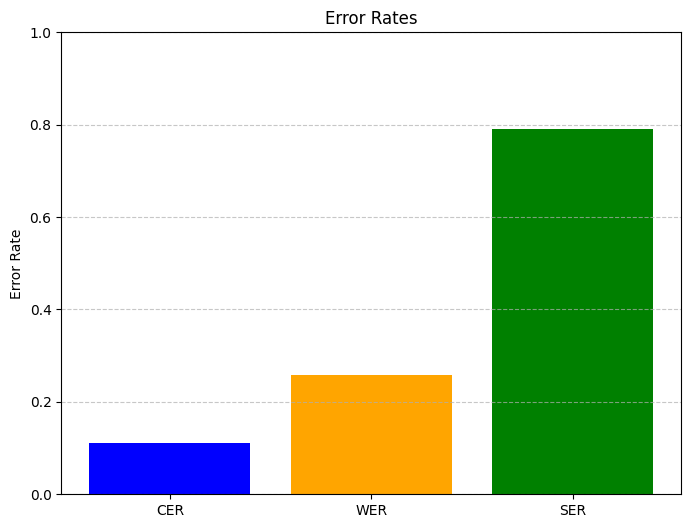

In [25]:
import matplotlib.pyplot as plt


error_types = ['CER', 'WER', 'SER']
error_rates = [evaluate[0],evaluate[1], evaluate[2]]

plt.figure(figsize=(8, 6))
plt.bar(error_types, error_rates, color=['blue', 'orange', 'green'])
plt.title('Error Rates')
plt.ylabel('Error Rate')
plt.ylim(0, 1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### The cells below are for finetuning based on the given Spanish Literature.

In [38]:
import cv2
import numpy as np
import pytesseract
import os
import h5py
import pandas as pd
from torch.utils.data import Dataset



import cv2
import numpy as np
import pytesseract
import os
import h5py
import pandas as pd
from torch.utils.data import Dataset



def crop_dict(page):

    page = cv2.imread(page)
    master_page_par_line_list = []

    image = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2GRAY)
    _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    data = pytesseract.image_to_data(image,config='--oem 3 --psm 6', output_type='dict')

    page_num = 1

    df = pd.DataFrame(data)
    df = df[df["conf"] > 0]
    df["page_num"] = page_num

    page_par_line_dict = {}
    for index, row in df.iterrows():
        page_par_line = f"{page_num}_{row['par_num']}_{row['line_num']}"
        if(page_par_line not in page_par_line_dict):
            page_par_line_dict[page_par_line] = {"text": str(row["text"]) + " ", "box": (row['left'], row['top'], row['left'] + row['width'], row['top'] + row['height'])}
        else:
            page_par_line_dict[page_par_line]["text"] = page_par_line_dict[page_par_line]["text"] + str(row["text"]) + " "
            page_par_line_dict[page_par_line]['box'] = (min(page_par_line_dict[page_par_line]['box'][0], row['left']), 
                                                    min(page_par_line_dict[page_par_line]['box'][1], row['top']), 
                                                    max(page_par_line_dict[page_par_line]['box'][2], row['left'] + row['width']), 
                                                    max(page_par_line_dict[page_par_line]['box'][3], row['top'] + row['height']))


    for entry in page_par_line_dict:
        splitted_key = entry.split('_')
        entry_value = page_par_line_dict[entry]
        master_page_par_line_list.append({
            'page_number' : splitted_key[0],
            'paragraph_number' : splitted_key[1],
            'line_number' : splitted_key[2],
            'entry_text' : entry_value['text'],
            'bounding_box' : entry_value['box']
        })

    imgs_cropped = {}


    img_text_dict = {"dt" : [], "gt" : []}

    for line in page_par_line_dict.values():
        if line['box'] is not None:
            cv2.rectangle(image, (line['box'][0], line['box'][1]), (line['box'][2], line['box'][3]), (0, 0, 255), 2)
            img_cropped = image[line['box'][1]:line['box'][3], line['box'][0]:line['box'][2]]
            if not os.path.exists('cropped_lines'):
                os.makedirs('cropped_lines')
            cv2.imwrite(f"cropped_lines/{line['box'][1]}.jpg", img_cropped)
#             print(line['text'])
            imgs_cropped[line['box'][1]] = img_cropped 
            assert os.path.exists(f'cropped_lines/{line["box"][1]}.jpg')
            img_text_dict["dt"].append(preprocess(f"cropped_lines/{line['box'][1]}.jpg",(1024,128,1)))
            img_text_dict["gt"].append(line['text'].encode())

    return img_text_dict




class DataGenerator_Sp(Dataset):
    def __init__(self, source_dict, charset, max_text_length, transform, shuffle=True):
        self.tokenizer = Tokenizer(charset, max_text_length)
        self.transform = transform
        self.shuffle = shuffle
        self.dataset = source_dict.copy() 
        
        if self.shuffle:
            randomize = np.arange(len(self.dataset['gt']))
            np.random.seed(42)
            np.random.shuffle(randomize)

            self.dataset['dt'] = np.array(self.dataset['dt'])[randomize]
            self.dataset['gt'] = np.array(self.dataset['gt'])[randomize]

        self.dataset['gt'] = [x.decode() for x in self.dataset['gt']]
            
        self.size = len(self.dataset['gt'])

    def __getitem__(self, i):
        img = self.dataset['dt'][i]
    
        img = np.repeat(img[..., np.newaxis], 3, -1)    
        img = normalization(img)
        
        if self.transform is not None:
            img = self.transform(img)

        y_train = self.tokenizer.encode(self.dataset['gt'][i]) 
 
        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)

        return img, gt          

    def __len__(self):
        return self.size

    



In [40]:
cropped = os.listdir("/kaggle/input/spanish-cropped/cropped_pages")
cropped_sorted = sorted([filename for filename in cropped if filename.endswith('.jpg')], key=lambda x: int(os.path.splitext(x)[0]))
print(cropped_sorted)
c_list = []

for i in cropped_sorted:
    c_list.append(crop_dict(f"/kaggle/input/spanish-cropped/cropped_pages/{i}"))

c_dict_train = {}

for c_dict in c_list[:22]:
    for key, value in c_dict.items():
        if key in c_dict_train:
            c_dict_train[key].extend(value)
        else:
            c_dict_train[key] = value[:]

c_dict_valid = {}

for c_dict in c_list[22:28]:
    for key, value in c_dict.items():
        if key in c_dict_valid:
            c_dict_valid[key].extend(value)
        else:
            c_dict_valid[key] = value[:]


['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg']


In [41]:
span_train_loader = torch.utils.data.DataLoader(DataGenerator_Sp(c_dict_train, charset_base,max_text_length,transform), batch_size=1, shuffle=False, num_workers=2)
span_valid_loader =  torch.utils.data.DataLoader(DataGenerator_Sp(c_dict_valid, charset_base,max_text_length,transform), batch_size=1, shuffle=False, num_workers=2)

In [42]:
pretrained_model = make_model(vocab_len = 100)
_=pretrained_model.to(device)

pretrained_model.load_state_dict(torch.load('/kaggle/input/pretrain_bentham/pytorch/bentham_pretrain/1/bentham_pretrained_model.pt'))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [43]:
criterion = LabelSmoothing(size=100, padding_idx=0, smoothing=0.1)
criterion.to(device)
lr = .0001 # learning rate
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=lr,weight_decay=.0004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)


/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [30]:
def train(model, criterion, optimiser, scheduler,dataloader):
 
    model.train()
    total_loss = 0
    for batch, (imgs, labels_y,) in enumerate(dataloader):
          imgs = imgs.to(device)
          labels_y = labels_y.to(device)
    
          optimiser.zero_grad()
          output = model(imgs.float(),labels_y.long()[:,:-1])
 
          norm = (labels_y != 0).sum()
#           print("Output shape:", output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size+1).shape)
          loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size+1), labels_y[:,1:].contiguous().view(-1).long()) / norm
 
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
          optimizer.step()
          total_loss += loss.item() * norm
 
    return total_loss / len(dataloader)
 
def evaluate(model, criterion, dataloader,):
 
    model.eval()
    epoch_loss = 0
 
    with torch.no_grad():
      for batch, (imgs, labels_y,) in enumerate(dataloader):
            imgs = imgs.to(device)
            labels_y = labels_y.to(device)
 
            output = model(imgs.float(),labels_y.long()[:,:-1])
              
            norm = (labels_y != 0).sum()
            loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size+1), labels_y[:,1:].contiguous().view(-1).long()) / norm
  
            epoch_loss += loss.item() * norm
 
    return epoch_loss / len(dataloader)

In [35]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
 

train_losses = []
valid_losses = []
best_valid_loss = np.inf
c = 0


for epoch in range(150):
 
    print(f'Epoch: {epoch+1:02}','learning rate{}'.format(scheduler.get_last_lr()))
    
    start_time = time.time()
 
    train_loss = train(pretrained_model,  criterion, optimizer, scheduler, span_train_loader)
    valid_loss = evaluate(pretrained_model, criterion, span_valid_loader)
 
    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
 
    c+=1
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(pretrained_model.state_dict(), target_path)
        c=0
 
    if c>4:
        scheduler.step()
        c=0
 
    print(f'Time: {epoch_mins}m {epoch_secs}s') 
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Val   Loss: {valid_loss:.3f}')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

        
torch.save(pretrained_model.state_dict(), 'span_fine_tuned_model.pt')



Epoch: 01 learning rate[0.0001]
Time: 0m 54s
Train Loss: 42.616
Val   Loss: 29.884
Epoch: 02 learning rate[0.0001]
Time: 0m 53s
Train Loss: 23.926
Val   Loss: 25.867
Epoch: 03 learning rate[0.0001]
Time: 0m 52s
Train Loss: 18.046
Val   Loss: 28.416
Epoch: 04 learning rate[0.0001]
Time: 0m 51s
Train Loss: 14.200
Val   Loss: 24.779
Epoch: 05 learning rate[0.0001]
Time: 0m 51s
Train Loss: 12.346
Val   Loss: 26.891
Epoch: 06 learning rate[0.0001]
Time: 0m 52s
Train Loss: 11.107
Val   Loss: 28.437
Epoch: 07 learning rate[0.0001]
Time: 0m 52s
Train Loss: 9.837
Val   Loss: 28.319
Epoch: 08 learning rate[0.0001]
Time: 0m 52s
Train Loss: 8.635
Val   Loss: 28.231
Epoch: 09 learning rate[0.0001]
Time: 0m 51s
Train Loss: 8.158
Val   Loss: 26.993
Epoch: 10 learning rate[9.5e-05]
Time: 0m 52s
Train Loss: 7.153
Val   Loss: 28.223
Epoch: 11 learning rate[9.5e-05]
Time: 0m 51s
Train Loss: 6.718
Val   Loss: 26.577
Epoch: 12 learning rate[9.5e-05]
Time: 0m 51s
Train Loss: 5.979
Val   Loss: 28.079
Epoch:

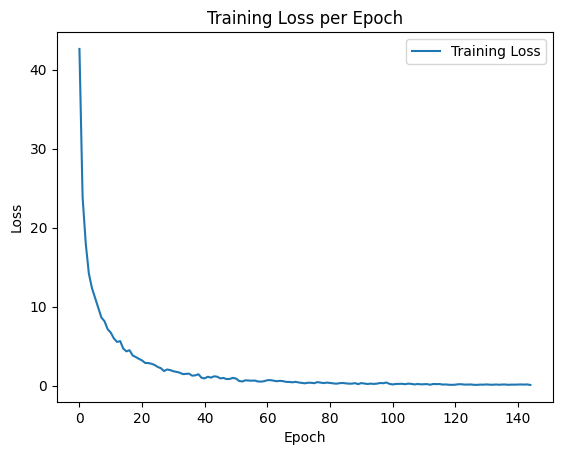

In [34]:
import matplotlib.pyplot as plt


plt.plot([loss.cpu().item() for loss in train_losses], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()


In [56]:
pretrained_model = make_model(vocab_len=100)
_= pretrained_model.to(device)

pretrained_model.load_state_dict(torch.load('/kaggle/input/spanish_fine_tune/pytorch/spanish_fine_tune/1/span_fine_tuned_model.pt'))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

### Sample Output

In [62]:

img_path = "/kaggle/input/spanish-cropped/cropped_pages/6.jpg"
sp_loader = torch.utils.data.DataLoader(DataGenerator_Sp(crop_dict(img_path),charset_base,max_text_length,transform, shuffle=False), batch_size=1, shuffle=False, num_workers=2)
predicts2, gt2, imgs = test(pretrained_model, sp_loader, max_text_length)

predicts2 = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts2))
gt2 = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt2))


In [66]:
for i in range(len(gt2)):
    print(f"Line {i+1} \n")
    print("Ground Truth: \n", gt2[i])
    print("Prediction: \n", predicts2[i])
    print("-----\n")

Line 1 

Ground Truth: 
 gg ee
Prediction: 
  | 
-----

Line 2 

Ground Truth: 
 mucha
Prediction: 
 
-----

Line 3 

Ground Truth: 
 yo defleo , y que os de larga
Prediction: 
 yo defleo , y que os de larga
-----

Line 4 

Ground Truth: 
  ( ade immortal , que a los mortales
Prediction: 
  ( ade immortal , que a los mortales
-----

Line 5 

Ground Truth: 
 ore yfus obras , y fegun la difinen
Prediction: 
 ore yfus obras , y fegun la difinen
-----

Line 6 

Ground Truth: 
 adelante lo particular ) dize Arilto - 
Prediction: 
 SEN COE AOE AOE E AOE EJOS
-----

Line 7 

Ground Truth: 
 viue rectamente , y Ja que yo creo
Prediction: 
 Siae Fecameze , y Ja que yo creo
-----

Line 8 

Ground Truth: 
 queesla virtud de que aqui os ha - 
Prediction: 
 gueesla Virrad de que aqui os fa - 
-----

Line 9 

Ground Truth: 
 gloria . 
Prediction: 
 gg ) za . 
-----

Line 10 

Ground Truth: 
 vida para grangear
Prediction: 
 S Ga ga gany gaz
-----

Line 11 

Ground Truth: 
 3andole con pidirfela , y 

### For all samples, Average Error Rates for all the spanish documents.

In [57]:
images_directory = "/kaggle/input/spanish-cropped/cropped_pages/"
image_paths = [os.path.join(images_directory, filename) for filename in os.listdir(images_directory)]

cer_list = []
wer_list = []
ser_list = []


for img_path in image_paths:
    sp_loader = torch.utils.data.DataLoader(DataGenerator_Sp(crop_dict(img_path), charset_base, max_text_length, transform),
                                             batch_size=1, shuffle=False, num_workers=2)
    
    predicts, gt, _ = test(pretrained_model, sp_loader, max_text_length)  # Replace test function with your actual testing logic
    
    predicts = [pred.replace('SOS', '').replace('EOS', '') for pred in predicts]
    gt = [ground_truth.replace('SOS', '').replace('EOS', '') for ground_truth in gt]
    
    evaluate_result = ocr_metrics(predicts=predicts, ground_truth=gt)  # Replace ocr_metrics with your actual evaluation function
    
    cer_list.append(evaluate_result[0])
    wer_list.append(evaluate_result[1])
    ser_list.append(evaluate_result[2])

avg_cer = sum(cer_list) / len(cer_list)
avg_wer = sum(wer_list) / len(wer_list)
avg_ser = sum(ser_list) / len(ser_list)


print("Average CER: {:.4f}".format(avg_cer))
print("Average WER: {:.4f}".format(avg_wer))
print("Average SER: {:.4f}".format(avg_ser))

Average CER: 0.1393
Average WER: 0.2544
Average SER: 0.4896


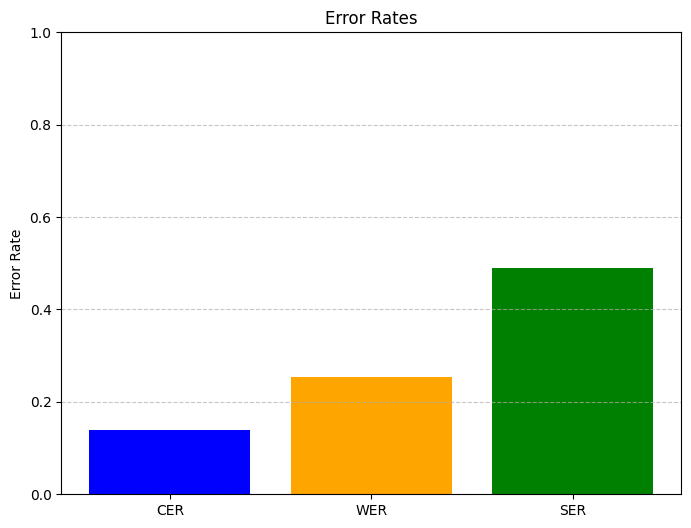

In [60]:
import matplotlib.pyplot as plt

error_types = ['CER', 'WER', 'SER']
error_rates = [avg_cer, avg_wer, avg_ser]

plt.figure(figsize=(8, 6))
plt.bar(error_types, error_rates, color=['blue', 'orange', 'green'])
plt.title('Error Rates')
plt.ylabel('Error Rate')
plt.ylim(0, 1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()